In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Read data

In [2]:
df = pd.read_csv("../assets/TaiwanAirBox032017.csv").set_index("time")
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,8.234563,34.357744,41.250916,41.194228,45.758237,40.424591,36.281097,37.844685,37.835138,44.057510,...,49.152261,55.091967,44.177585,42.569721,34.833622,38.084488,44.854870,46.933081,45.600072,52.152083
2,8.074951,34.455387,39.598679,41.088167,44.970358,39.865248,37.668302,37.439057,37.459381,43.493874,...,48.586604,54.930351,44.329101,41.317196,34.651804,38.463276,45.044264,46.254293,45.387951,51.495833
3,7.918439,34.622896,38.476926,41.116787,44.305423,39.256782,39.073064,37.170659,37.277562,43.126450,...,48.238119,54.718230,44.596777,40.512650,34.616450,38.384003,45.359416,45.830051,45.212193,51.370833
4,7.629787,35.000000,37.800159,41.273497,43.786231,38.687338,38.924916,37.083538,37.134224,42.761130,...,47.738119,54.557624,45.104353,40.027802,34.730447,38.954315,45.789719,45.850253,45.290981,51.386458
5,7.533917,35.494949,37.146960,41.534969,43.316534,38.307347,38.754882,37.050830,37.390285,42.526281,...,47.731806,54.065200,45.814310,39.700529,34.954690,39.820982,46.716991,45.994192,45.903860,51.488542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,47.250000,11.000000,1.500000,4.250000,2.142857,3.000000,3.600000,1.000000,3.571429,1.857143,...,35.125000,43.250000,35.142857,27.250000,20.857143,34.142857,40.800000,32.375000,33.500000,35.000000
741,48.333333,16.333333,2.750000,6.166667,3.500000,4.250000,4.000000,2.500000,5.000000,3.000000,...,40.000000,42.222222,32.571429,19.600000,20.800000,31.500000,38.166667,32.000000,34.500000,37.500000
742,47.666667,18.833333,1.600000,4.857143,2.500000,34.114722,3.750000,2.400000,3.000000,2.400000,...,38.000000,43.000000,32.142857,14.666667,17.666667,19.000000,35.428571,30.333333,34.222222,35.333333


In [3]:
locations = pd.read_csv("../assets/locations032017.csv", index_col=0)
locations.index = "V" + locations.index.astype(str)
locations.index.name = "device"
locations

,latitude,longitude
device,,
V1,1.306,103.920
V2,23.741,120.755
V3,25.073,121.536
V4,25.119,121.505
V5,25.056,121.552
...,...,...
V512,23.366,120.366
V513,22.954,120.244
V514,22.945,120.230


# 2.1 Remove seasonality

See seasonality.ipynb


We remove the seasonality via Ridge regression and take the residuals as our new df for the rest of the exploration.

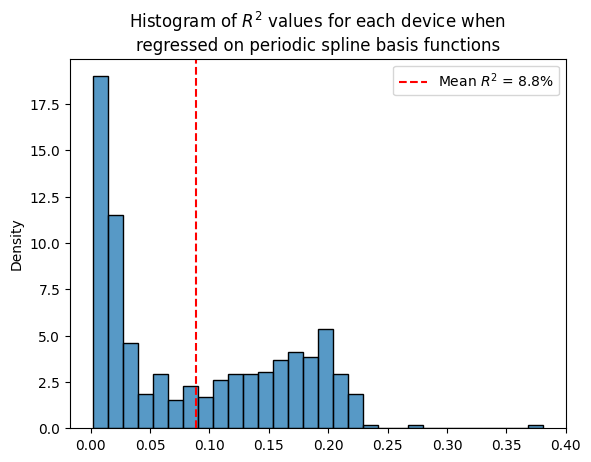

In [4]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

N_SPLINES = 5

df_hour = df.assign(hour=(np.arange(len(df)) % 24))
splines = periodic_spline_transformer(24, n_splines=N_SPLINES).fit_transform(df_hour[["hour"]])
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
df_hour_spline = df_hour.merge(splines_df, how = "left", left_on = "hour", right_index = True).drop(columns = "hour")

r2s = []
residuals = []
for target_col in df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")]:
    # get ridgecv r^2
    ridgecv = RidgeCV()
    ridgecv.fit(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col])
    r2s.append(ridgecv.score(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col]))
    # get residuals
    residuals.append(df_hour_spline[target_col] - ridgecv.predict(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]]))

r2s = pd.Series(r2s, index = df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")])
sns.histplot(r2s, bins = 30, stat = "density")
plt.title("Histogram of $R^2$ values for each device when\nregressed on periodic spline basis functions")
plt.axvline(r2s.mean(), color = "red", linestyle = "--", label = f"Mean $R^2$ = {r2s.mean() * 100:.1f}%")
plt.legend()

residuals = pd.concat(residuals, axis = 1)
df = residuals

# 2.2. Model base + evaluation

In [5]:
df.iloc[:, 0].head(10)

time
1    -22.358607
2    -22.727265
3    -23.128789
4    -23.641384
5    -23.883089
6    -23.805548
7    -23.265176
8    -22.415107
9    -17.882062
10   -22.360926
Name: V1, dtype: float64

In [6]:
from sklearn.linear_model import RidgeCV
from abc import ABC, abstractmethod
from tqdm import tqdm

class Model(ABC):
    """
    Important:  make sure model.lookback and model.horizon are defined,
    these are used for the get_stats function.
    """
    @abstractmethod
    def fit(self, data):
        """
        Fits a h-step ahead model to the data.
        Forgets the previous fit if model was already fit.

        Parameters
        ----------
        data : pd.DataFrame
            The data to fit the model to.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.

        horizon : int
            The number of steps ahead to forecast.
        """
        ...

    @abstractmethod
    def predict(self, data):
        """
        Predicts X_{t+h} given X_t
        for each X_t (row) in the dataframe `data`.

        Parameters
        ----------
        data : pd.DataFrame
            The data to predict on.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.

        Returns
        -------
        pd.DataFrame
            The predicted values.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.
        """
        ...


class ARRidgeModel(Model):
    def __init__(self, lookback=5, horizon=1):
        self.lookback = lookback
        self.horizon = horizon

    def fit(self, data):
        models = [RidgeCV() for _ in range(len(data.columns))]
        for col_index, model in enumerate(models):
            col = data.iloc[:, col_index]
            # X[t, :] = [X[t - 0], X[t - 1], ..., X[t - lookback + 1]] (`lookback` lags)
            # y[t] = X[t + horizon] (horizon steps ahead)

            y = col[self.lookback + self.horizon - 1:]
            X = pd.concat([
                col.iloc[i: -self.lookback + i].reset_index(drop=True)
                for i in range(self.lookback)
            ], axis=1, keys=[f"lag_{self.lookback - i - 1}" for i in range(self.lookback)])
            X.index = data.index[self.lookback - 1:-self.horizon]
            y.index = X.index

            model.fit(X, y)


        self.models = models

    def predict(self, data):
        out = []
        for col_index, model in enumerate(self.models):
            col = data.iloc[:, col_index]
            X = pd.concat([
                col.iloc[i: -self.lookback + i].reset_index(drop=True)
                for i in range(self.lookback)
            ], axis=1, keys=[f"lag_{self.lookback - i - 1}" for i in range(self.lookback)])
            X.index = data.index[self.lookback - 1:-self.horizon]
            out.append(model.predict(X))
        return pd.DataFrame(np.array(out).T, index=data.index[self.lookback - 1:-self.horizon], columns=data.columns)

model = ARRidgeModel()
model.fit(df)

In [7]:
model.predict(df)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
5,-21.682353,0.223701,8.983611,5.612678,9.501003,6.853769,7.097564,6.765468,4.045412,5.993598,...,-16.942542,-3.018670,-14.978877,3.783839,-3.446644,-11.443108,-21.613378,-8.752126,-14.773734,-6.116023
6,-21.591452,0.493870,8.633394,6.139769,9.210288,6.474889,6.908281,7.220754,4.410997,5.806847,...,-18.129543,-4.235062,-14.314708,2.188252,-3.470697,-10.848140,-20.639686,-8.802287,-14.282061,-5.788156
7,-21.067645,0.476853,8.145504,6.023197,8.491807,6.048843,6.913790,7.379876,4.728783,5.520507,...,-19.381078,-5.498614,-13.598271,-0.203403,-3.097624,-10.209805,-19.871332,-8.908728,-13.874037,-5.491088
8,-20.330930,0.226513,7.853297,5.823320,8.116561,5.404821,6.875912,7.239227,4.732986,5.291494,...,-20.204063,-6.827250,-11.971206,-2.789408,-2.472307,-9.165387,-18.590842,-8.692083,-12.877199,-5.186484
9,-15.709314,2.714665,0.802837,14.081735,1.338553,3.164821,14.402792,3.724942,-1.393948,7.367726,...,-15.250869,23.320126,-17.546674,-8.180144,-10.234762,-11.457952,-23.412798,-19.141454,-19.741932,4.211165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,8.580954,-28.112787,-26.484404,-31.623017,-32.513768,-28.942085,-28.582487,-29.184693,-30.432734,-33.549752,...,-17.863331,-18.514157,-11.866136,-4.294423,-10.203857,-13.259180,-12.564655,-9.469028,-11.430482,-13.460778
740,15.915634,-27.499491,-25.989900,-31.608428,-31.368717,-29.701510,-27.920277,-29.597872,-29.862667,-34.838831,...,-14.143209,-9.532217,-12.916963,-11.104247,-12.186427,-9.920424,-11.154008,-9.703351,-15.103460,-16.269375
741,15.544080,-20.916870,-24.678826,-30.247749,-30.396814,-28.205910,-28.024739,-28.193853,-28.612425,-33.810721,...,-12.817133,-12.053579,-17.387960,-17.250535,-11.997322,-15.324315,-17.251464,-12.158558,-15.865551,-14.117851


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_stats(test_data, fitted_model):
    yhat = fitted_model.predict(test_data)
    y = test_data.iloc[fitted_model.lookback + fitted_model.horizon - 1:]
    y.index = yhat.index

    y_flat = y.values.flatten()
    yhat_flat = yhat.values.flatten()

    return pd.Series({
        "mse": mean_squared_error(y_flat, yhat_flat),
        "mae": mean_absolute_error(y_flat, yhat_flat),
        "r2": r2_score(y_flat, yhat_flat)
    })

get_stats(df, model) # in-sample stats

mse    47.848986
mae     4.404042
r2      0.792403
dtype: float64

# 3. Crossval

# 3.1. Crossval visualisation

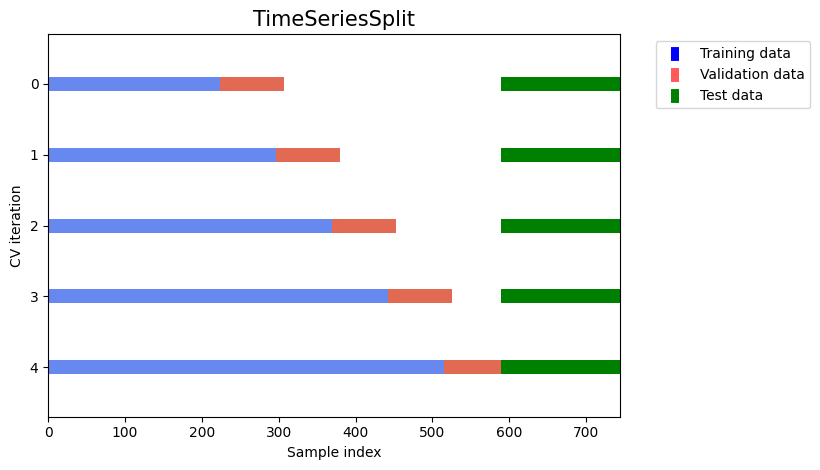

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, TimeSeriesSplit

cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, data_train, data, ax, n_splits, lw=10, lookback = 1, horizon = 1):
    """Create a sample plot for indices of a cross-validation object."""

    # Actual data column doesn't matter for CV visualization
    col = data_train.iloc[:, 0]
    # X[t, :] = [X[t - 0], X[t - 1], ..., X[t - lookback + 1]] (`lookback` lags)
    # y[t] = X[t + horizon] (horizon steps ahead)

    y = col[lookback + horizon - 1:]
    X = pd.concat([
        col.iloc[i: -lookback + i].reset_index(drop=True)
        for i in range(lookback)
    ], axis=1, keys=[f"lag_{lookback - i - 1}" for i in range(lookback)])
    X.index = data_train.index[lookback - 1:-horizon]
    y.index = X.index

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

        # we also draw the test data from (len(X) to len(data))
        # green line
        ax.scatter(
            range(len(X), len(data)),
            [ii + 0.5] * (len(data) - len(X)),
            marker="_",
            lw=lw,
            #c=[1] * (len(data) - len(X)),
            #cmap=cmap_cv,
            #vmin=-0.2,
            #vmax=1.2,
            # we make it green
            c = "green"
        )

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2],
        xlim=[0, len(data)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


TEST_FRAC = 0.2
n_train = int(len(df) * (1 - TEST_FRAC))
n_test = len(df) - n_train
df_train, df_test = df.iloc[:n_train], df.iloc[n_train:]

fig, ax = plt.subplots()
n_splits = 5
cv = TimeSeriesSplit(n_splits, test_size = (len(df) - 5) // 10)
plot_cv_indices(cv, df_train, df, ax, n_splits)
fig.tight_layout()

ax.scatter([], [], marker="_", lw=10, label="Training data", c="b")
ax.scatter([], [], marker="_", lw=10, label="Validation data", c="r", alpha=0.65)
ax.scatter([], [], marker="_", lw=10, label="Test data", c="g")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Our CV is set up such that we use at least half the data for training.

For the validation, we use 5 folds, and the test set is the last 20% of the data.

# 3.2. Cross-val grid search

In [10]:
def crossval(data, model, cv, horizon = 1, lookback = 5):
    stats = []
    for train_index, test_index in cv.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        model.fit(train)
        stats.append(get_stats(test, model))
    stats = pd.DataFrame(stats).T
    stats.columns.name = "fold"
    stats["mean"] = stats.mean(axis=1)
    return stats

print(crossval(df_train, ARRidgeModel(lookback = 1), cv))
print(crossval(df_train, ARRidgeModel(lookback = 5), cv))

fold          0          1          2          3          4       mean
mse   70.187324  47.686269  47.832806  37.023556  41.785026  48.902996
mae    4.647180   4.636637   4.504642   4.020366   4.588580   4.479481
r2     0.648015   0.726763   0.726193   0.689365   0.718776   0.701823
fold          0          1          2          3          4       mean
mse   60.196229  49.060620  47.499132  36.254889  41.529029  46.907980
mae    4.441183   4.718353   4.469165   3.993278   4.548881   4.434172
r2     0.668922   0.727272   0.722503   0.700933   0.714550   0.706836


In [11]:
from joblib import Parallel, delayed

grid = {
    "lookback": [1, 3, 5, 7, 9, 11, 13, 15]
}

def loss(lookback):
    model = ARRidgeModel(lookback = lookback)
    stats = crossval(df_train, model, cv, lookback = lookback)
    return stats.loc["mse", "mean"] # mean mse across folds

# grid search the loss function
results = pd.DataFrame({
    "lookback": grid["lookback"],
    #"mse": [loss(lookback) for lookback in grid["lookback"]]
    "mse": Parallel(n_jobs=-1)(delayed(loss)(lookback) for lookback in grid["lookback"])
})


Text(0.5, 1.0, 'Grid search')

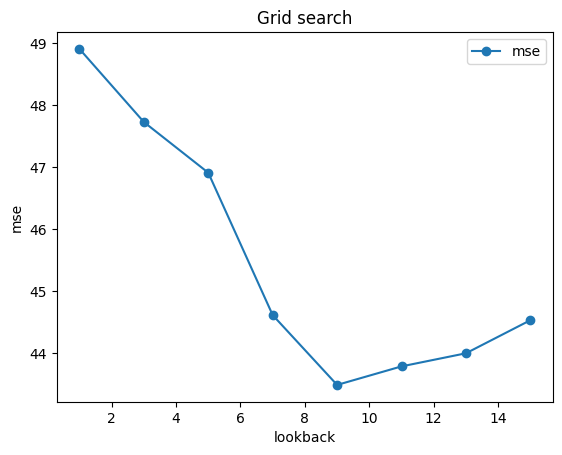

In [12]:
results.plot(x="lookback", y="mse", marker="o")
plt.xlabel("lookback")
plt.ylabel("mse")
plt.title("Grid search")

In [13]:
model = ARRidgeModel(lookback = 9)
model.fit(df_train)
get_stats(df_test, model)

mse    50.310484
mae     4.601180
r2      0.802167
dtype: float64

Naive autoregressive Ridge model per series with a lag length of 9 (found by crossval) leads to a test MSE of 51.629.

# 4.1. VAR model: RRPack

In [14]:
#from statsmodels.tsa import vector_ar
#class VARModel(Model):
    #def __init__(self, lookback=5, horizon=1):
        #self.lookback = lookback
        #self.horizon = horizon

    #def fit(self, data):
        ## each row is a time period, each column is a device
        #self.model = vector_ar.VAR(data)
        

    #def predict(self, data):
        #out = []
        #for col_index, model in enumerate(self.models):
            #col = data.iloc[:, col_index]
            #out.append(model.forecast(col.values[-self.lookback:], self.horizon))
        #return pd.DataFrame(np.array(out).T, index=data.index[-self.horizon:], columns=data.columns)

In [15]:
import os
os.environ['R_HOME'] = '/usr/lib/R'

import rpy2
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.packages import importr
pandas2ri.activate()

sparsevar = importr('sparsevar')
rrpack = importr('rrpack')

In [16]:
r_df_train = pandas2ri.py2rpy(df_train)

In [17]:
#res = sparsevar.fitVAR(r_df_train, p = 1, penalty="ENET", method="cv", scale = True, parallel = True, ncores = 12, nlambda = 64)
X = r["as.matrix"](pandas2ri.py2rpy(df_train.iloc[:-1]))
# add intercept
X = r["cbind"](1, X)
Y = r["as.matrix"](pandas2ri.py2rpy(df_train.iloc[1:]))
Y = r["cbind"](1, Y)
#X = pd.DataFrame(np.random.randn(10, 100))
#Y = pd.DataFrame(np.random.randn(10, 100))
res = rrpack.rrr(Y, X, penaltySVD ="ann", ic_type = "GCV")

<Axes: >

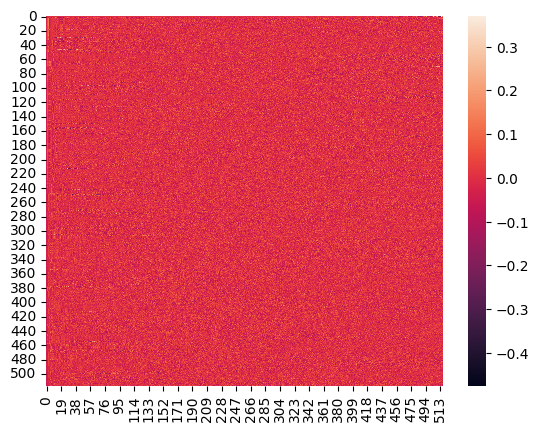

In [18]:
# get res$A
coef = res.rx2("A")
sns.heatmap(coef)

In [19]:
X.shape, Y.shape, coef.shape

((594, 517), (594, 517), (517, 517))

In [20]:
Y - X @ coef.T

array([[ -3.5833279 , -19.38265533,   7.96005932, ..., -23.85667145,
         -7.48744107, -12.6874672 ],
       [ -2.92254227, -20.14997132,   7.97227607, ..., -26.61862811,
         -5.04304636, -13.85447095],
       [ -2.52768482, -21.1935413 ,   8.301457  , ..., -28.39854154,
         -3.28156611, -14.29666495],
       ...,
       [  0.511549  ,  -5.99293626,   0.91654323, ...,  -4.92643795,
          2.72893167, -24.03668282],
       [  3.72070265,  -1.81599531,  12.42775952, ...,  -7.57452429,
         -1.69422494, -17.3104241 ],
       [  2.98180202,  -2.80451586,  19.95549613, ...,  -0.67999609,
         11.62233431, -24.36329081]])

In [21]:
# get residuals
residuals = Y - X @ coef.T
# drop the intercept
residuals = residuals[:, 1:]
residuals = pd.DataFrame(np.array(residuals), index = df_train.index[1:], columns = df_train.columns)
residuals


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
2,-19.382655,7.960059,20.466985,-3.595201,2.422476,13.073676,23.011046,11.762980,13.883106,7.281696,...,-25.575007,18.045365,-28.183232,-5.715720,-7.646794,-14.178491,-24.809648,-23.856671,-7.487441,-12.687467
3,-20.149971,7.972276,19.848858,-1.049786,2.599564,13.940197,23.897404,12.816029,14.974261,9.035135,...,-26.767994,16.934921,-27.257746,-7.731710,-6.481584,-15.053233,-27.600922,-26.618628,-5.043046,-13.854471
4,-21.193541,8.301457,19.971846,1.349392,3.154496,14.387851,22.749451,14.130508,15.556722,10.305057,...,-27.911509,15.842154,-25.818060,-8.912971,-4.734140,-15.313544,-29.600213,-28.398542,-3.281566,-14.296665
5,-21.940764,8.500787,19.388171,4.069408,3.566760,14.397025,21.132180,15.296556,16.475474,11.250326,...,-28.438104,14.109274,-24.229157,-10.207916,-2.518605,-15.304573,-30.619786,-29.725383,-1.334387,-14.268641
6,-22.399830,8.475822,18.084769,5.508719,4.212827,13.664103,19.771094,16.361156,17.265251,11.292357,...,-29.268751,11.646940,-22.772198,-11.901270,-0.802021,-15.000570,-31.101730,-30.270466,0.269504,-13.288469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,3.611089,-4.225868,-14.709330,-37.765916,-28.075302,15.506183,-20.281187,-25.506178,-5.699090,-43.923861,...,-19.426109,-43.770611,-22.555807,-37.650959,4.804224,-24.028955,-21.309082,-18.025370,6.086246,-21.347143
592,-0.472705,2.429290,-16.032987,-41.726696,-17.545892,14.575483,-21.567650,-23.741239,4.861587,-49.589178,...,-9.404660,-34.412851,-18.562090,-28.398273,4.473997,-7.830706,-19.419684,-0.620348,9.757512,-24.329335
593,-5.992936,0.916543,-15.233595,-30.093294,-13.047763,7.285616,-16.704239,-29.038697,6.039836,-49.535753,...,-5.620153,-31.166223,-16.474844,-29.500746,0.460672,-20.161802,-32.457828,-4.926438,2.728932,-24.036683


# 4.2. Crossval model per cluster

In [22]:
class PerClusterModel(Model):
    def __init__(self, model_generator, clusters):
        self.model_generator = model_generator
        self.clusters = clusters # a list of lists of strings [["V1", ...], ...]

        # ASSUMES ALL MODELS HAVE THE SAME LOOKBACK AND HORIZON
        dummy_model = model_generator()
        self.lookback = dummy_model.lookback
        self.horizon = dummy_model.horizon

    def fit(self, data):
        self.models = [self.model_generator() for _ in range(len(self.clusters))]
        for model, cluster in zip(self.models, self.clusters):
            model.fit(data[cluster])
        

    def predict(self, data):
        # We have to ensure the output is in the same order as data.columns
        out = []
        for model, cluster in zip(self.models, self.clusters):
            out.append(
                pd.DataFrame(model.predict(data[cluster]), columns=cluster)
            )

        return pd.concat(out, axis=1).reindex(data.columns, axis=1)

In [23]:
# Two models, one for the first 100 columns, one for the rest
model = PerClusterModel(lambda: ARRidgeModel(lookback = 5), [df_train.columns[100:], df_train.columns[:100]])
print(crossval(df_train, model, cv))

fold          0          1          2          3          4       mean
mse   60.196229  49.060620  47.499132  36.254889  41.529029  46.907980
mae    4.441183   4.718353   4.469165   3.993278   4.548881   4.434172
r2     0.668922   0.727272   0.722503   0.700933   0.714550   0.706836


In [24]:
print(crossval(df_train, ARRidgeModel(lookback = 5), cv))

fold          0          1          2          3          4       mean
mse   60.196229  49.060620  47.499132  36.254889  41.529029  46.907980
mae    4.441183   4.718353   4.469165   3.993278   4.548881   4.434172
r2     0.668922   0.727272   0.722503   0.700933   0.714550   0.706836


Cluster model works, leads to same results as the non-clustered model for the ARRidgeModel (as expected).

# 4.3. Read cluster

In [25]:
import json

with open("../out/clustering_results.json", "r") as f:
    clustering_results = json.load(f)

clustering_results = pd.DataFrame(clustering_results)
clustering_results

,acf,cc,gcc
0,"{'n_clusters': 2, 'n_lags': 1, 'silhouette_sco...","{'n_clusters': 2, 'n_lags': 11, 'silhouette_sc...","{'n_clusters': 2, 'n_lags': 4, 'silhouette_sco..."
1,"{'n_clusters': 2, 'n_lags': 2, 'silhouette_sco...","{'n_clusters': 2, 'n_lags': 12, 'silhouette_sc...","{'n_clusters': 2, 'n_lags': 5, 'silhouette_sco..."
2,"{'n_clusters': 2, 'n_lags': 5, 'silhouette_sco...","{'n_clusters': 2, 'n_lags': 13, 'silhouette_sc...","{'n_clusters': 2, 'n_lags': 3, 'silhouette_sco..."
3,"{'n_clusters': 2, 'n_lags': 3, 'silhouette_sco...","{'n_clusters': 2, 'n_lags': 14, 'silhouette_sc...","{'n_clusters': 2, 'n_lags': 2, 'silhouette_sco..."
4,"{'n_clusters': 2, 'n_lags': 9, 'silhouette_sco...","{'n_clusters': 2, 'n_lags': 6, 'silhouette_sco...","{'n_clusters': 2, 'n_lags': 6, 'silhouette_sco..."
5,"{'n_clusters': 3, 'n_lags': 2, 'silhouette_sco...","{'n_clusters': 8, 'n_lags': 2, 'silhouette_sco...","{'n_clusters': 9, 'n_lags': 10, 'silhouette_sc..."
6,"{'n_clusters': 3, 'n_lags': 7, 'silhouette_sco...","{'n_clusters': 8, 'n_lags': 3, 'silhouette_sco...","{'n_clusters': 9, 'n_lags': 11, 'silhouette_sc..."
7,"{'n_clusters': 3, 'n_lags': 9, 'silhouette_sco...","{'n_clusters': 8, 'n_lags': 5, 'silhouette_sco...","{'n_clusters': 9, 'n_lags': 12, 'silhouette_sc..."
8,"{'n_clusters': 3, 'n_lags': 14, 'silhouette_sc...","{'n_clusters': 8, 'n_lags': 6, 'silhouette_sco...","{'n_clusters': 9, 'n_lags': 13, 'silhouette_sc..."
9,"{'n_clusters': 3, 'n_lags': 10, 'silhouette_sc...","{'n_clusters': 9, 'n_lags': 6, 'silhouette_sco...","{'n_clusters': 9, 'n_lags': 14, 'silhouette_sc..."


In [26]:
CLUSTER_TYPE = "acf" # acf | cc | gcc
CLUSTER_INDEX = 0 # [0, len(clustering_results[CLUSTER_TYPE]))
CLUSTER_METHODOLOGY = "kmedoids" # kmedoids | hierarchical

cluster_info = pd.Series(clustering_results.loc[CLUSTER_INDEX, CLUSTER_TYPE])
print(cluster_info)
if CLUSTER_METHODOLOGY == "kmedoids":
    cluster = cluster_info["labels_kmedoids"]
elif CLUSTER_METHODOLOGY == "hierarchical":
    cluster = cluster_info["labels_hierarchical"]
else:
    raise ValueError("CLUSTER_METHODOLOGY must be kmedoids or hierarchical")

assert len(cluster) == len(df_train.columns), "Cluster length does not match number of columns in df_train"

n_clusters                                                                       2
n_lags                                                                           1
silhouette_score_kmedoids                                                 0.099124
labels_kmedoids                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
silhouette_score_hierarchical                                             0.110453
labels_hierarchical              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
dtype: object


# 4.4. Sparse VAR model

In [27]:
class SparseVAR(Model):
    def __init__(self, lookback=5, horizon=1, penalty = "ENET", method = "cv", scale = True, parallel = True, ncores = 12, nlambda = 64):
        self.lookback = lookback
        self.horizon = horizon
        self.penalty = penalty
        self.method = method
        self.scale = scale
        self.parallel = parallel
        self.ncores = ncores
        self.nlambda = nlambda

    def fit(self, data):
        # each row is a time period, each column is a device

        #self.models = []
        #for col in data.columns:
            #r_df_train = pandas2ri.py2rpy(data[col])
            #res = sparsevar.fitVAR(r_df_train, p = self.lookback, penalty=self.penalty, method=self.method, scale = self.scale, parallel = self.parallel, ncores = self.ncores, nlambda = self.nlambda)
            #self.models.append(res)

        # we fit a single sparseVAR on all data
        r_df_train = pandas2ri.py2rpy(data)
        res = sparsevar.fitVAR(r_df_train, p = self.lookback, penalty=self.penalty, method=self.method, scale = self.scale, parallel = self.parallel, ncores = self.ncores, nlambda = self.nlambda)

        self.model = res
        self.coefs = list(res.rx2("A")) # contains self.lookback matrices
        self.residuals = list(res.rx2("residuals"))

    # def predict(self, data):
    #     #out = []
    #     #for model in self.models:
    #         #out.append(model.forecast(self.horizon))
    #     #return pd.DataFrame(np.array(out).T, index=data.index[-self.horizon:], columns=data.columns)

    #     # we use the same model for all columns
    #     # r_df = pandas2ri.py2rpy(data)

    #     # Y_t = self.coefs[0] X_{t-1} + ... + self.coefs[lookback - 1] X_{t - lookback}
        
    #     y_hat = sum(
    #         #self.coefs[i] @ data.to_numpy()[self.lookback - i - 1: -self.horizon - i].T
    #         data.to_numpy()[self.lookback - i - 1: -self.horizon - i] @ self.coefs[i]
    #         for i in range(self.lookback)
    #     )
    #     return y_hat.T

    def predict(self, data):
        num_series = data.shape[1]  # Assuming data is a DataFrame where columns are series
        lookback = self.lookback

        # Initialize an array to hold the forecasts
        forecasts = np.zeros((data.shape[0] - lookback, num_series))

        for t in range(lookback, data.shape[0]):
            # Get the most recent 'lookback' observations up to time t
            recent_data = data.to_numpy()[t-lookback:t, :].T

            # Compute the forecast for time t
            forecast_t = np.zeros(num_series)
            for k in range(lookback):
                forecast_t += self.coefs[k] @ recent_data[:, -k]

            # Store the forecast
            forecasts[t - lookback, :] = forecast_t

        return pd.DataFrame(forecasts, index=data.index[lookback:], columns=data.columns)



model = SparseVAR(lookback = 1, horizon = 1)
model

In [28]:
model.fit(df_train.iloc[:, :10])

R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.1-8

R[write to console]: Loaded glmnet 4.1-8



<Axes: xlabel='time'>

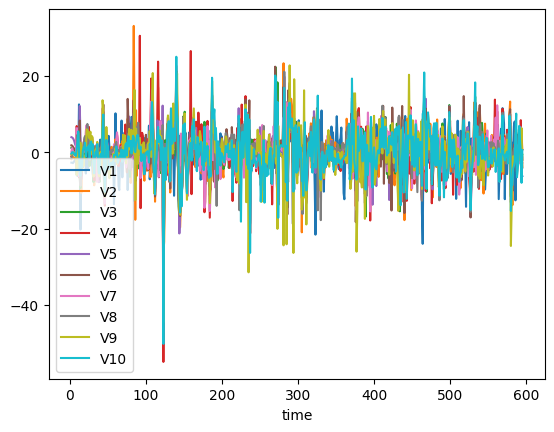

In [29]:
y_hat = model.predict(df_train.iloc[:, :10])
(df_train.iloc[1:, :10] - y_hat).plot()

<Axes: xlabel='time'>

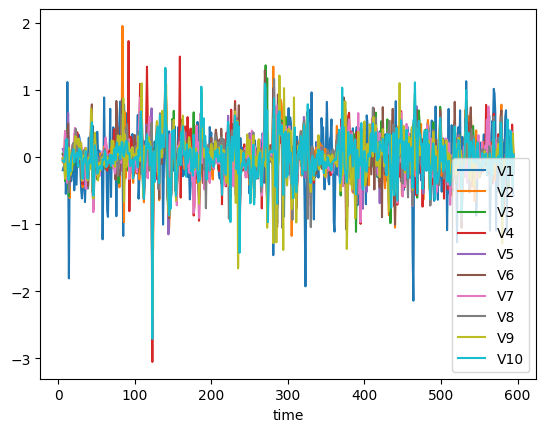

In [ ]:
pd.DataFrame(np.array(model.residuals), index = df_train.index, columns = df_train.columns[:10]).iloc[5:].plot()

We observe the residuals are correct: the model forecasts work!

(scale is different, but that's okay. It's fixed if you set scale = False)

In [41]:
print(crossval(df_train.iloc[:, :10], SparseVAR(lookback = 1), cv))
print(crossval(df_train.iloc[:, :10], ARRidgeModel(lookback = 2), cv))


fold          0          1          2          3          4       mean
mse   51.964151  24.951522  32.251164  27.263267  24.865298  32.259080
mae    5.244557   3.555360   4.301900   4.082300   3.539705   4.144764
r2     0.838266   0.835888   0.828999   0.835995   0.817362   0.831302
fold          0          1          2          3          4       mean
mse   59.804291  27.297230  34.191534  27.441502  27.583935  35.263698
mae    5.118653   3.659393   4.271460   4.069953   3.754757   4.174843
r2     0.815899   0.816901   0.819729   0.836651   0.798007   0.817437


In [31]:
model.model.rx2("time")

array([0.23937631])